In [1]:
# Reload dependencies upon changes
%load_ext autoreload
%autoreload 2

## Dependencies

In [2]:
from functools import partial
from itertools import product
from copy import deepcopy
import typing
import sys
import pickle

import numpy as np
import gym
import tqdm
import matplotlib.pyplot as plt

from mazelab_experimenter import EnvRegister
from mazelab_experimenter import AgentShelve
from mazelab_experimenter import benchmark, GenericOuterHook


# Result output format.
FILE_FORMAT = 'pdf'
OUTPUT_FORMAT = 'figures/ablation_{}.' + FILE_FORMAT

print("Output figures will be formatted as:", OUTPUT_FORMAT.format("FILENAME"))

Output figures will be formatted as: figures/ablation_FILENAME.pdf


## Environment Definition

We explore simple gridworld environments presenting tabular features to the agents. We test our agents on an empty world and on a world with rooms, we keep the dimensionality small due to memory requirements incurred by either the hindsight tables or eligibility trace models.

The agents/ environments are initialized with a binary reward function, i.e., a function that always returns $0$ until a desired state is reached upon which it returns $1$.

In [3]:
t = 10_000  # Number of steps before terminating an episode for any agent on all environments.

name_grid10 = EnvRegister.register(
    maze_type='gridworld', 
    name=f'gridworld-v0', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(height=12, width=12),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[10, 10]]
    ),
    time_limit=t,
    override=True
)

name_grid20 = EnvRegister.register(
    maze_type='gridworld', 
    name=f'gridworld-v1', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(height=22, width=22),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[20, 20]]
    ),
    time_limit=t,
    override=True
)

name_rooms4 = EnvRegister.register(
    maze_type='n_rooms_square', 
    name=f'n_rooms-v0', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(num_rooms=4, room_size=5, gap_size=1),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[7, 7]]
    ),
    time_limit=t,
    override=True
)

name_rooms9 = EnvRegister.register(
    maze_type='n_rooms_square', 
    name=f'n_rooms-v1', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(num_rooms=9, room_size=5, gap_size=1),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[13, 13]]
    ),
    time_limit=t,
    override=True
)

# Collect each individual environment.
environment_names = [name_grid10, name_grid20, name_rooms4, name_rooms9]
environment_labels = ['10x10 Gridworld', '20x20 Gridworld', '4-rooms 5-to-1', '9-rooms 5-to-1']

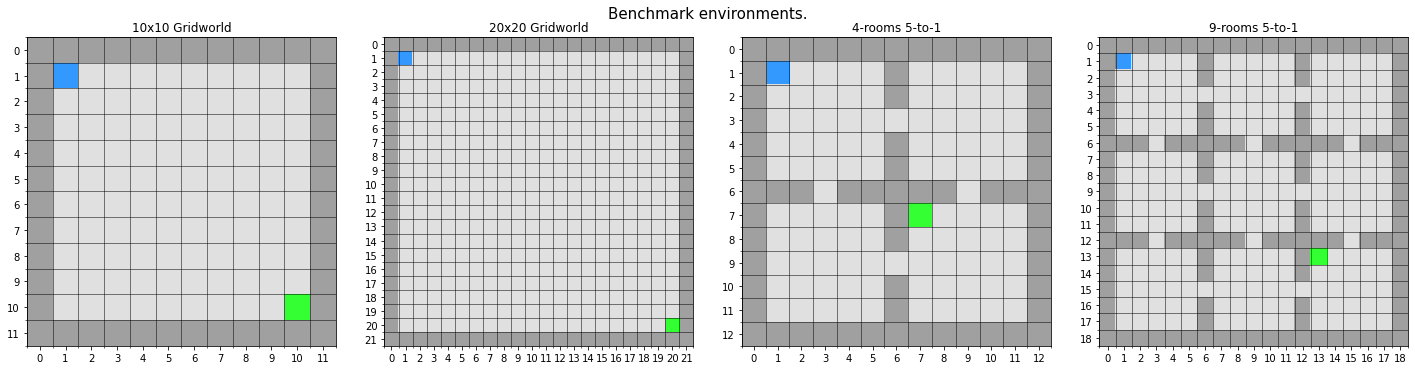

In [4]:
# Create and show an example visualization of the environment
dummy_images = list()
for name in environment_names:
    dummy = gym.make(name)
    dummy.reset()
    
    dummy_images.append(dummy.unwrapped.get_image())
    dummy.close()
    
fig, ax = plt.subplots(1, len(environment_names), figsize=(5 * len(environment_names), 5))
for i, img in enumerate(dummy_images):
    # Plot image with border padding
    ax[i].imshow(img)
    
    # Grid lines
    major, minor = np.arange(0, len(img), 1), np.arange(-.5, len(img), 1)
    ax[i].set_xticks(major); ax[i].set_yticks(major)            # Major plot ticks
    ax[i].set_xticklabels(major); ax[i].set_yticklabels(major)  # Major plot tick-labels
    ax[i].set_xticks(minor, minor=True); ax[i].set_yticks(minor, minor=True)  # Minor ticks for Grid-lines.
    
    ax[i].grid(which='minor', color='black', linestyle='-', linewidth=.5)
    
    # Annotations
    ax[i].set_title(environment_labels[i])

plt.suptitle("Benchmark environments.", fontsize=15)
plt.tight_layout()

plt.savefig(OUTPUT_FORMAT.format('BenchmarkEnvironment', FILE_FORMAT), format=FILE_FORMAT, bbox_inches="tight")
plt.show()

## Experiment Multi-Step Returns: Agent Definition 

For benchmarking the agents we utilize two types of implemented classes for either the flat or the hierarchical agents. These are the atomic and compound update types, note that an atomic 1-step update $\equiv$ to a $\lambda=0$ compound update which is just 1-step $TD$. For $\lambda=0$ we can fall back to the multi-step implementation with $n=1$ for simplicity, we test out both methods to demonstrate empirical equivalence to assert that the implementation is correct.

In [5]:
# Shared Keyword arguments
shared_kwargs = {
    'epsilon': 0.25,
    'discount': 0.95,
    'lr': 1.0
}

# Defaults for Hierarchical agents.
hierarchical_defaults = {
    'horizons': 3,
    'relative_goals': True,
    'universal_top': False
}

# Defaults for the Flat agents.
flat_defaults = {
    'replace': True  # Replacing eligiblity trace. TODO: True Online update?
}


def create_agent_generator(_env: gym.Env, hierarchical: bool, atomic: bool, **kwargs) -> typing.Callable:
    """ Helper function for instantiating agents with a fixed goal given some environment. 
    
    Atomic implies n-step returns, otherwise implies compound/ lambda returns.
    Hierarchical denotes whether to use a hierarchical Q-learner or a flat agent.
    
    Actual agent hyperparameters 'v' should be specified outside this function.
    """
    if hierarchical:
        agent = AgentShelve.retrieve(
            agent=('HierQN' if atomic else 'HierQLambda'),  
            keyword_arguments=dict(
                observation_shape=_env.observation_space.shape,
                n_actions=_env.action_space.n,
                **kwargs, **hierarchical_defaults, **shared_kwargs
            ))
        agent.set_goal(agent._get_index(_env.unwrapped.maze.get_end_pos()[0]))
    else:
        agent = AgentShelve.retrieve(
            agent=('TabularQLearnerN' if atomic else 'TabularQLambda'),  
            keyword_arguments=dict(
                observation_shape=_env.observation_space.shape,
                n_actions=_env.action_space.n,
                **kwargs, **flat_defaults, **shared_kwargs
            ))
        
    return agent


def get_environment_agent_ablations(_env_name: str, ablation_grid: typing.Dict) -> typing.List[typing.Generator]:
    """ Helper function for creating agent generators with an environment dependency over a grid of parameters. """
    dummy = gym.make(_env_name)
    
    # Unpack all ablation-runs over their parameter grid into flat lists.
    meta, agent_generators, separators = list(), list(), list()
    for name, ablations in ablations_grid.items():
        # Take cartesian product of all specified parameter options.
        keys, values = zip(*ablations.items())
        grid = [dict(zip(keys, v)) for v in product(*values)]
        
        # Initialize agents.
        for p in grid:
            gen = partial(create_agent_generator, _env=dummy, **p)
       
            # Add agent generator and ablation metadata to global execution list.        
            agent_generators.append(gen)
            meta.append(p)
        
        # Append grid length to separate list for slicing convenience.
        separators.append(len(grid))
        
    return meta, agent_generators, separators
        

# Define (ad-hoc) Parameter Ablation Grid and wrap into generator function.
ablations_grid = {
    'lambda_flat': {'hierarchical': [False], 'atomic': [False], 'decay': [0.0, 0.4, 0.8, 1.0]},
    'multistep_flat': {'hierarchical': [False], 'atomic': [True], 'n_steps': [1, 2, 3, 5]},
    'lambda_hierarchical': {'hierarchical': [True], 'atomic': [False], 'decay': [0.0, 0.4, 0.8, 1.0], 'n_levels': [2, 3]},
    'multistep_hierarchical': {'hierarchical': [True], 'atomic': [True], 'n_steps': [1, 2, 3, 5], 'n_levels': [2, 3]}
}
# Use this function with an environment arguments to get all agents specified by the parameter grid as generators.
# >> meta, agents, seps = get_environment_ablations(env_name)
get_environment_ablations = partial(get_environment_agent_ablations, ablation_grid=ablations_grid)

### Run Benchmark & IO

In [ ]:
# Benchmark configuration
r = 50
it = 50
eps = 1
trials = 5
verbose = True

# Benchmark data for each agent.
benchmark_data = list()
for env_name in environment_names:
    print("=" * 50 + "\nExperiment environment:", env_name, end='\n\n')
    meta, agent_gens, separators = get_environment_ablations(env_name)
    
    env_data = list()
    for i, (m, gen_a) in enumerate(zip(meta, agent_gens)):
        print(f"Benchmarking agent: {i}/{len(meta)} -", m)
        
        # Run the benchmark
        env_data.append(
            benchmark(
                env_id=env_name, 
                _agent_gen=gen_a, 
                agent_test_kwargs=dict(behaviour_policy=False),
                agent_train_kwargs=dict(),
                skip_random_evaluation=True,
                num_repetitions=r,
                num_iterations=it,
                num_episodes=eps,
                num_trials=trials,
                evaluation_hooks=[GenericOuterHook()],
                verbose=verbose,
                asynchronous=False
            )
        )
        
    benchmark_data.append({'name': env_name, 'meta': meta, 'data': env_data, 'separators': separators})
    

Experiment environment: gridworld-v0

Benchmarking agent: 0/24 - {'hierarchical': False, 'atomic': False, 'decay': 0.0}
-- Benchmarking Repetition 1 / 50 --- ETA:  --- Rate: 0 sec/ it --- Total: 0.00 min
Train-Test loop: 100%|█████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.14it/s]
-- Benchmarking Repetition 2 / 50 --- ETA: 0:02:31 --- Rate: 3 sec/ it --- Total: 0.05 min
Train-Test loop: 100%|█████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.57it/s]
-- Benchmarking Repetition 3 / 50 --- ETA: 0:02:49 --- Rate: 3 sec/ it --- Total: 0.12 min
Train-Test loop: 100%|█████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.54it/s]
-- Benchmarking Repetition 4 / 50 --- ETA: 0:02:35 --- Rate: 3 sec/ it --- Total: 0.17 min
Train-Test loop: 100%|█████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.54it/s]
-- Benchmarking Repetition 5 / 50 --- ETA: 

In [7]:
with open('multistep_lambdaCorrection.out', 'wb') as f:
    pickle.dump(benchmark_data, f)

[autoreload of mazelab_experimenter.agents.HierarchicalAgents.HierQLambda failed: Traceback (most recent call last):
  File "C:\Users\joery\Anaconda3\envs\mazelab\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\joery\Anaconda3\envs\mazelab\lib\site-packages\IPython\extensions\autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "C:\Users\joery\Anaconda3\envs\mazelab\lib\site-packages\IPython\extensions\autoreload.py", line 347, in update_generic
    update(a, b)
  File "C:\Users\joery\Anaconda3\envs\mazelab\lib\site-packages\IPython\extensions\autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "C:\Users\joery\Anaconda3\envs\mazelab\lib\site-packages\IPython\extensions\autoreload.py", line 347, in update_generic
    update(a, b)
  File "C:\Users\joery\Anaconda3\envs\mazelab\lib\site-packages\IPython\extensions\autoreload.py

## Visualization

In [23]:
def plot_expectation(canvas, xs: np.ndarray, ydata: np.ndarray, repetition_size: int, axis: int = 0, label: str = None, color: str = None, style: str = None) -> None:
    # Helper function for plotting the mean performance with approximation error of the mean.
    mean = ydata[...,axis][...,0].mean(axis=0)
    stderr = ydata[...,axis][...,0].std(axis=0) / np.sqrt(repetition_size)

    canvas.plot(xs, mean, label=label, linewidth=2, linestyle=style, color=color)
    canvas.fill_between(xs, mean + stderr, mean - stderr, alpha=0.1, color=color)
    

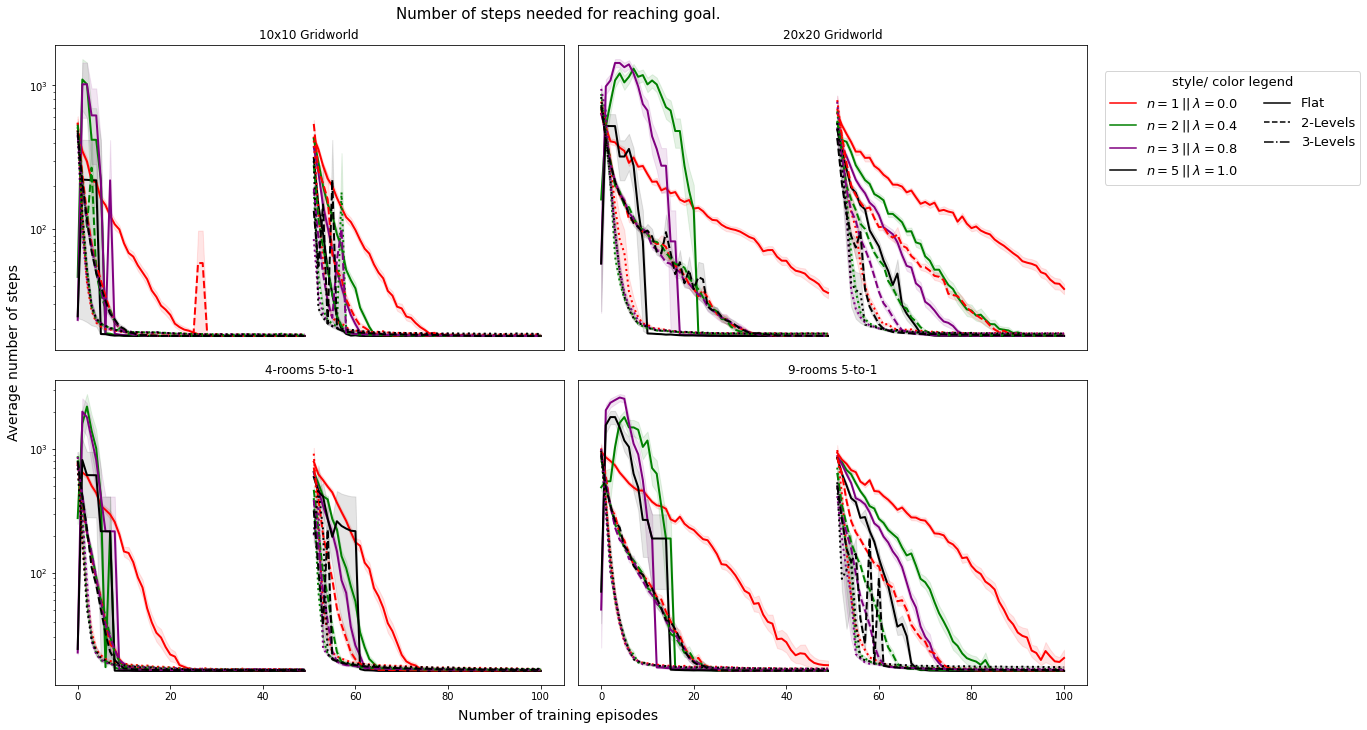

In [40]:
# Define some annotation helper functions
def get_style(hierarchical: bool, **params: dict) -> str:
    if hierarchical:
        return '--' if params['n_levels'] == 2 else 'dotted'
    return '-'


def get_color(atomic: bool, **params: dict) -> str:
    if atomic:
        d = {1: 'red', 2: 'green', 3: 'purple', 5: 'black'}
        return d[params['n_steps']]
    else:
        d = {0.0: 'red', 0.4: 'green', 0.8: 'purple', 1.0: 'black'}
        return d[params['decay']]


# Create figure
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

axis = 2
for env_i, env_data in enumerate(benchmark_data):
    canvas = ax[env_i // 2, env_i % 2]
    
    name, meta, data, sep = env_data.values()
    for param_i, arr in enumerate(data):
#         if meta[param_i]['hierarchical']:
           
#             if meta[param_i]['n_levels'] == 3:
#                 pass
#         else: continue
        xs = np.arange(it)
        if meta[param_i]['atomic']:
            xs += len(xs) + 1
    
        plot_expectation(canvas, xs, np.asarray(arr), r, axis, color=get_color(**meta[param_i]), style=get_style(**meta[param_i]))
#         canvas.set_ylim([0, t+1])
        canvas.set_yscale('log')
        
        canvas.set_title(environment_labels[env_i])
        if env_i % 2 != 0:
            canvas.get_yaxis().set_visible(False)
        if env_i // 2 == 0:
            canvas.get_xaxis().set_visible(False)
    
# Add Legend
plt.plot([], [], color='red', label=r'$n=1 \: || \: \lambda = 0.0$')
plt.plot([], [], color='green', label=r'$n=2\: || \: \lambda = 0.4$')
plt.plot([], [], color='purple', label=r'$n=3\: || \: \lambda = 0.8$')
plt.plot([], [], color='black', label=r'$n=5\: || \: \lambda = 1.0$')

plt.plot([], [], linestyle='-', color='black', label=r'Flat')
plt.plot([], [], linestyle='--', color='black', label=r'2-Levels')
plt.plot([], [], linestyle='-.', color='black', label=r'3-Levels')

fig.legend(fontsize=13, ncol=2, title='style/ color legend', bbox_to_anchor=(1.0, 0.9), loc='upper left', title_fontsize=13)
    
# Plot annotations
fig.text(0.5, -0.01, 'Number of training episodes', fontsize=14, ha='center')
fig.text(-0.01, 0.5, 'Average number of steps', fontsize=14, va='center', rotation='vertical')
    
plt.suptitle("Number of steps needed for reaching goal.", fontsize=15)

plt.tight_layout()
plt.show()

{1: {'decay': [64.90288000000001, 80.30968, 90.22784, 34.30127999999999], 'n_steps': [63.9892, 44.65616, 36.614560000000004, 29.176959999999998]}, 2: {'decay': [40.02904, 40.50472, 35.0748, 35.64456], 'n_steps': [42.868320000000004, 27.680159999999997, 26.524719999999995, 28.1448]}, 3: {'decay': [32.04711999999999, 31.446479999999998, 29.676240000000004, 31.385920000000002], 'n_steps': [30.166159999999998, 26.02088, 20.666079999999997, 24.939839999999997]}}
{1: {'decay': [584.0884, 1612.40136, 1292.3308, 280.53183999999993], 'n_steps': [605.74568, 337.54848, 248.85544, 188.17728]}, 2: {'decay': [251.95455999999996, 259.8684, 244.7296, 256.3912], 'n_steps': [269.2184, 172.0348, 139.08016, 110.20591999999999]}, 3: {'decay': [194.67888, 181.39184, 213.13975999999997, 176.28912000000003], 'n_steps': [179.18912, 138.23032, 142.82336, 118.0972]}}
{1: {'decay': [112.58808, 157.20192, 152.18976, 80.244], 'n_steps': [109.04536, 70.8856, 59.1336, 74.75808]}, 2: {'decay': [47.631840000000004, 49.

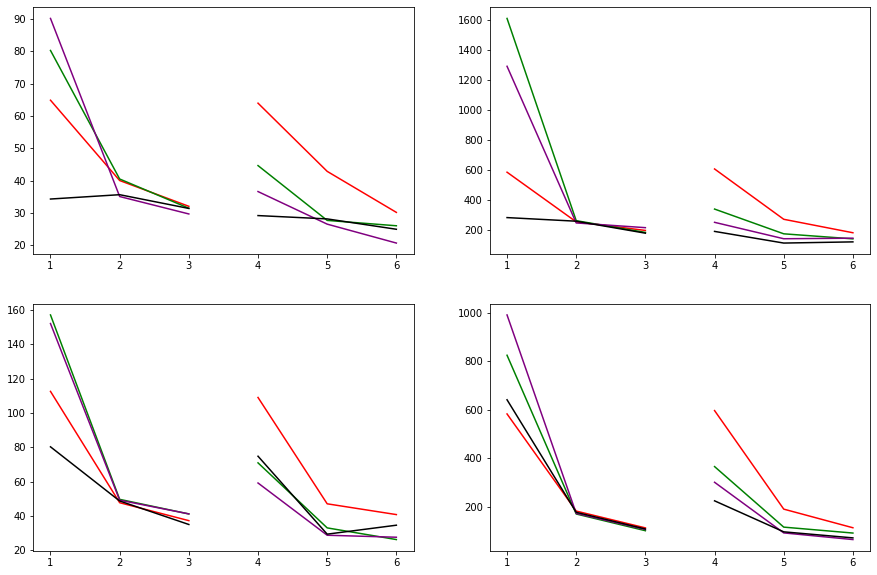

In [59]:
# Define some annotation helper functions
def get_style(hierarchical: bool, **params: dict) -> str:
    if hierarchical:
        return '--' if params['n_levels'] == 2 else 'dotted'
    return '-'


def get_color(atomic: bool, **params: dict) -> str:
    if atomic:
        d = {1: 'red', 2: 'green', 3: 'purple', 5: 'black'}
        return d[params['n_steps']]
    else:
        d = {0.0: 'red', 0.4: 'green', 0.8: 'purple', 1.0: 'black'}
        return d[params['decay']]


# Create figure
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

axis = 2
for env_i, env_data in enumerate(benchmark_data):
    canvas = ax[env_i // 2, env_i % 2]
    
    averages = {
        1: {'decay': [0.] * 4, 'n_steps': [0.] * 4},
        2: {'decay': [0.] * 4, 'n_steps': [0.] * 4},
        3: {'decay': [0.] * 4, 'n_steps': [0.] * 4}
    }
    avg_flat = list()
    
    name, meta, data, sep = env_data.values()
    for param_i, arr in enumerate(data):
        avg_flat.append(np.asarray(arr)[..., axis].mean())
    
#     print(meta, averages)
    for param_i, avg in enumerate(avg_flat):
        
        n = 1 if not meta[param_i]['hierarchical'] else meta[param_i]['n_levels']
        if 'decay' in meta[param_i]:
            m = {0.0: 0, 0.4: 1, 0.8: 2, 1.0: 3}
            averages[n]['decay'][m[meta[param_i]['decay']]] += (avg - averages[n]['decay'][m[meta[param_i]['decay']]])
        else:
            m = {1: 0, 2: 1, 3: 2, 5: 3}
            averages[n]['n_steps'][m[meta[param_i]['n_steps']]] += (avg - averages[n]['n_steps'][m[meta[param_i]['n_steps']]])
            
    print(averages)
    
    c = ['red', 'green', 'purple', 'black']
    for x in range(4):
        
        decay = [v['decay'][x] for v in averages.values()]
        n_steps = [v['n_steps'][x] for v in averages.values()]
        
        xs = np.arange(1, 4)
        canvas.plot(xs, decay, color=c[x])
        canvas.plot(xs+3, n_steps, color=c[x])
        
# #         if meta[param_i]['hierarchical']:
           
# #             if meta[param_i]['n_levels'] == 3:
# #                 pass
# #         else: continue
#         xs = np.arange(it)
#         if meta[param_i]['atomic']:
#             xs += len(xs) + 1
    
#         plot_expectation(canvas, xs, np.asarray(arr), r, axis, color=get_color(**meta[param_i]), style=get_style(**meta[param_i]))
# #         canvas.set_ylim([0, t+1])
#         canvas.set_yscale('log')
        
#         canvas.set_title(environment_labels[env_i])
#         if env_i % 2 != 0:
#             canvas.get_yaxis().set_visible(False)
#         if env_i // 2 == 0:
#             canvas.get_xaxis().set_visible(False)
    
# # Add Legend
# plt.plot([], [], color='red', label=r'$n=1 \: || \: \lambda = 0.0$')
# plt.plot([], [], color='green', label=r'$n=2\: || \: \lambda = 0.4$')
# plt.plot([], [], color='purple', label=r'$n=3\: || \: \lambda = 0.8$')
# plt.plot([], [], color='black', label=r'$n=5\: || \: \lambda = 1.0$')

# plt.plot([], [], linestyle='-', color='black', label=r'Flat')
# plt.plot([], [], linestyle='--', color='black', label=r'2-Levels')
# plt.plot([], [], linestyle='-.', color='black', label=r'3-Levels')

# fig.legend(fontsize=13, ncol=2, title='style/ color legend', bbox_to_anchor=(1.0, 0.9), loc='upper left', title_fontsize=13)
    
# # Plot annotations
# fig.text(0.5, -0.01, 'Number of training episodes', fontsize=14, ha='center')
# fig.text(-0.01, 0.5, 'Average number of steps', fontsize=14, va='center', rotation='vertical')
    
# plt.suptitle("Number of steps needed for reaching goal.", fontsize=15)

# plt.tight_layout()
# plt.show()

## Experiment Exploration and Bounding: Agent Definition 